Введение в проект

Вы работаете аналитиком в приложении по доставке готовых блюд. Перед вами результаты двух экспериментов:
	1.	Первый эксперимент: Тестирование типов фотографий блюд:
	•	Группа A: Прямоугольные изображения (16:9).
	•	Группа B: Квадратные изображения.
	•	Группа C: Прямоугольные изображения (12:4).
Цель: Определить, какой формат изображений больше увеличивает заказы.
	2.	Второй эксперимент: Изменение дизайна кнопки заказа:
	•	Control: Старая версия кнопки.
	•	Test: Новая версия кнопки.
Цель: Проверить, влияет ли новая кнопка на заказы.

Основные задачи
	1.	Анализ первого теста (изображения):
	•	Проверить распределение и гомогенность данных.
	•	Провести однофакторный дисперсионный анализ (ANOVA) и критерий Тьюки.
	•	Принять решение о формате изображений.
	2.	Анализ второго теста (кнопка):
	•	Сравнить распределения в контрольной и тестовой группах.
	•	Провести описательный анализ сегментов.
	•	Построить модель для проверки гипотезы.

**Ожидаемые результаты:**
- **Фотографии**: Рекомендации по формату изображений для увеличения заказов.
- **Кнопка**: Оценка влияния новой кнопки на поведение пользователей.
- **Навыки**: Закрепление методов статистического анализа и визуализации данных.
- **Решения**: Получение практического опыта формирования выводов на основе данных.

In [1]:
# Импортируем основные библиотеки для анализа данных и визуализации
import pandas as pd
import numpy as np
import pingouin as pg
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt  # Построение графиков
import seaborn as sns  # Красивые визуализации на основе Matplotlib
from scipy.stats import f_oneway, levene, shapiro  # Статистические тесты для ANOVA, гомогенности и нормальности
from statsmodels.stats.multicomp import (pairwise_tukeyhsd, MultiComparison) # Критерий Тьюки для анализа парных различий

plt.style.use('seaborn')  # Применяем стиль для визуализаций
sns.set_theme()  # Устанавливаем тему для Seaborn


/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of

In [2]:
# Загр узим данные
exp1 = pd.read_csv('5_task_1.csv')
exp2 = pd.read_csv('5_task_2.csv')

		exp1: Данные по тесту форматов изображений.
		exp2: Данные по тесту кнопки.

In [3]:
exp1.sample(5)

,id,group,events
10650,215,B,51
26568,27763,C,18
1111,15121,A,33
25084,20846,C,4
27675,24672,C,30


In [4]:
exp2.sample(5)

,id,group,segment,events
26207,36307,test,low,36.0
21550,30587,test,low,36.0
35828,91196,test,low,29.0
80916,67928,control,low,20.0
81512,84721,control,low,17.0


Почему мы это делаем:

Гомогенность дисперсий (или равенство дисперсий) — одно из ключевых предположений для проведения ANOVA.

Если дисперсии внутри групп различаются слишком сильно, результаты ANOVA могут быть некорректными.

In [5]:
# Проверка гомогенности дисперсий между группами
result_homogeneity = pg.homoscedasticity(data=exp1, dv='events', group='group')
print(result_homogeneity)

# Интерпретация результата:
# Если p-value > 0.05, дисперсии гомогенны, и мы можем использовать стандартную ANOVA.
# Если p-value < 0.05, дисперсии не равны, и ANOVA может быть некорректной.

              W      pval  equal_var
levene  2.26226  0.104133       True


В данном случае, pval = 0.10413, что больше 0.05. Это означает, что дисперсии между группами A, B и C равны, и мы можем продолжать использовать стандартный ANOVA.

Проверяем нормальности распределения

Почему это важно:

Для использования ANOVA необходимо, чтобы данные в каждой группе были нормально распределены. Если это предположение нарушено, результаты ANOVA могут быть некорректными.

In [6]:
# Проверка нормальности распределения в группах
result = pg.normality(data=exp1, dv='events', group='group', method='normaltest')
print(result)

# Интерпретация результата:
# Если p-value > 0.05, распределение нормальное.
# Если p-value < 0.05, распределение отличается от нормального.

          W      pval  normal
A  2.103460  0.349333    True
B  0.841072  0.656695    True
C  3.243726  0.197530    True


Выводы:

		Для всех групп (A, B, C) pval > 0.05, что означает, что распределение данных во всех группах можно считать нормальным.
		Мы можем использовать стандартный ANOVA для анализа различий между группами.


In [7]:
stat, p = levene(
        exp1[exp1['group'] == 'A'] ['events'],
        exp1[exp1['group'] == 'B']['events'],
        exp1[exp1['group'] == 'C'] ['events']
)

print(f"'Levene's test: p-value = {p:.4f}")

'Levene's test: p-value = 0.1041


В данном случае тоже тест Левена подтверждает гомогенность дисперсий между группами, что делает ANOVA подходящим методом анализа.

Q-Q Plots для проверки нормальности распределения

Q-Q Plots (квантиль-квантиль графики) визуализируют, насколько распределение данных в группе соответствует нормальному распределению. Если точки на графике располагаются вдоль диагонали, то распределение близко к нормальному.

<Figure size 792x504 with 0 Axes>

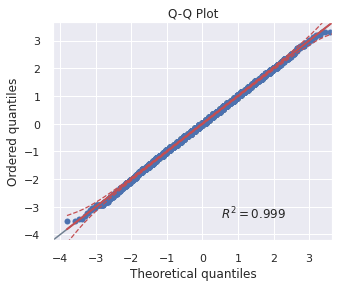

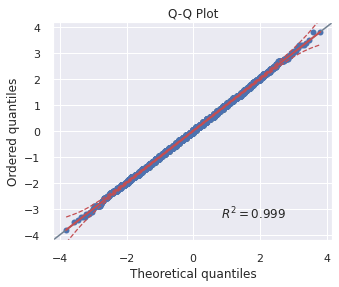

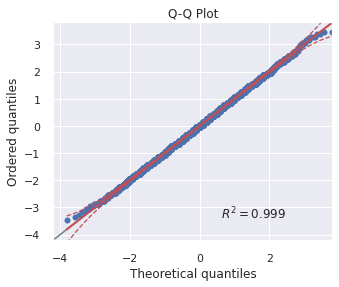

In [8]:
# Q-Q Plot для группы A
plt.figure(figsize=(11, 7))
pg.qqplot(exp1.query("group == 'A'")['events'])
plt.show()

# Q-Q Plot для группы B
pg.qqplot(exp1.query("group == 'B'")['events'])
plt.show()

# Q-Q Plot для группы C
pg.qqplot(exp1.query("group == 'C'")['events'])
plt.show()

Q-Q графики подтверждают выводы, сделанные ранее при помощи теста pg.normality.

		Во всех группах (A, B, C) данные соответствуют нормальному распределению.
		Можно переходить к проведению однофакторного дисперсионного анализа (ANOVA).

Проведение однофакторного дисперсионного анализа (ANOVA)

Цель:
    Проверить, есть ли статистически значимые различия между средними значениями групп (A, B, C).

In [9]:
# Проведение однофакторного дисперсионного анализа
stat, p_value = f_oneway(
    exp1[exp1['group'] == 'A']['events'],
    exp1[exp1['group'] == 'B']['events'],
    exp1[exp1['group'] == 'C']['events']
)

print(f"Значение статистики: {stat:.0f}")
print(f"P-уровень значимости: {p_value:.4f}")

Значение статистики: 2886
P-уровень значимости: 0.0000


P-value = 0 говорит о том, что между группами (A, B, C) существуют статистически значимые различия.

Это означает, что хотя бы одна из групп имеет среднее значение, значительно отличающееся от других

Критерий Тьюки

Цель: Определить, между какими группами (A, B, C) есть статистически значимые различия.

In [10]:
# Критерий Тьюки
tukey = pairwise_tukeyhsd(endog=exp1['events'], groups=exp1['group'], alpha=0.05)

# Вывод результата
print(tukey)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj  lower    upper  reject
----------------------------------------------------
     A      B    8.034 0.001   7.7038  8.3642   True
     A      C  -2.1093 0.001  -2.4395 -1.7791   True
     B      C -10.1433 0.001 -10.4735 -9.8131   True
----------------------------------------------------


	P-value 'reject':
		Если p-value < 0.05, мы отвергаем нулевую гипотезу, которая утверждает, что между группами нет значимых различий.
		Если p-value >= 0.05, мы не можем отвергнуть нулевую гипотезу, что означает, что различия статистически незначимы.

Все три пары групп (A vs B, A vs C, B vs C) показали значимые различия. Это указывает на то, что формат фотографий (разные группы) существенно влияет на поведение пользователей.

Еще два критерия для проверки

In [11]:
pg.pairwise_tukey(data = exp1, dv = 'events', between =  'group')

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,A,B,29.5796,37.6136,-8.0340,0.140894,-57.021604,0.001,-0.806377
1,A,C,29.5796,27.4703,2.1093,0.140894,14.970833,0.001,0.211712
2,B,C,37.6136,27.4703,10.1433,0.140894,71.992436,0.001,1.018089


In [12]:
pg.pairwise_gameshowell(data = exp1, dv = 'events', between = 'group')

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,A,B,29.5796,37.6136,-8.0340,0.140920,-57.011134,19987.258491,0.001,-0.806229
1,A,C,29.5796,27.4703,2.1093,0.141696,14.886135,19995.116233,0.001,0.210514
2,B,C,37.6136,27.4703,10.1433,0.140062,72.420220,19995.502469,0.001,1.024138


Оба метода дают одинаковый вывод: различия между всеми парами групп статистически значимы.
Группа B является наиболее эффективной, так как имеет наибольшее среднее значение events.

Вывод:
Методы Тьюки и Геймса-Хауэлла подтвердили, что формат фотографий оказывает значительное влияние на метрику events. Для максимального эффекта рекомендуется использовать формат группы B

Text(0, 0.5, 'Число покипок')

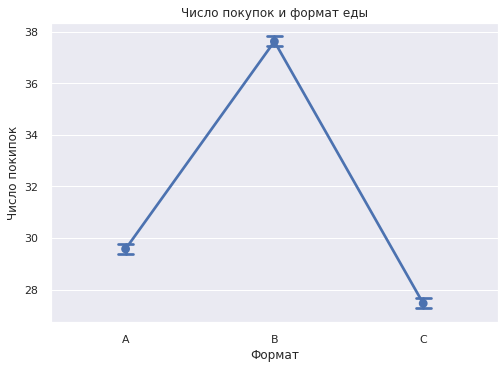

In [13]:
# Нарисуем, чтобы проще было смотреть

sns.pointplot(x = 'group', y = 'events', data = exp1, capsize = .1)
plt.title("Число покупок и формат еды")
plt.xlabel("Формат")
plt.ylabel("Число покипок")

### Выбор метода многофакторного дисперсионного анализа (ANOVA)

Многофакторный дисперсионный анализ (ANOVA) был выбран для исследования различий между группами, так как он:

- **Позволяет оценить влияние нескольких факторов.**
  - В данном случае это формат кнопки и сегмент пользователя, которые могут оказывать влияние на метрику `events`.
  
- **Учитывает взаимодействие между факторами.**
  - Это помогает понять их совокупное влияние на поведение пользователей и выявить возможные эффекты взаимодействия.

- **Является стандартным инструментом для анализа различий.**
  - Используется для оценки различий между средними значениями в нескольких группах, что важно для проверки гипотез.

График наглядно демонстрирует результаты анализа. На нем видно, что **группа B** имеет наиболее высокий показатель `events`. Это делает её предпочтительным выбором для реализации, так как она может способствовать увеличению заказов.

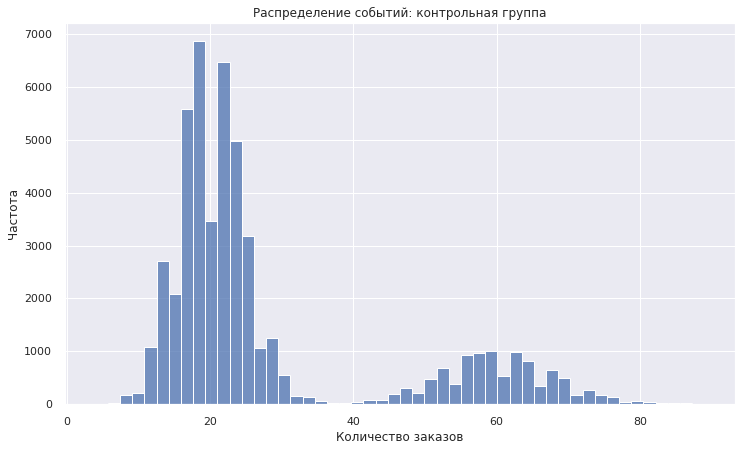

In [14]:
# Визуализация распределения для контрольной группы (старой кнопки)
plt.figure(figsize=(12, 7))  # Устанавливаем размер графика
sns.histplot(x=exp2.query("group == 'control'")['events'], bins=50)  # Строим гистограмму для группы 'control'
plt.title("Распределение событий: контрольная группа")
plt.xlabel("Количество заказов")
plt.ylabel("Частота")
plt.show()

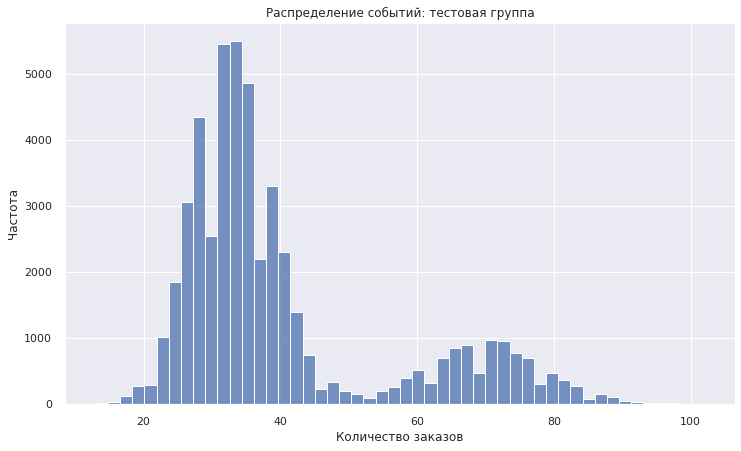

In [15]:
# Визуализация распределения для тестовой группы (новой кнопки)
plt.figure(figsize=(12, 7))  # Устанавливаем размер графика
sns.histplot(x=exp2.query("group == 'test'")['events'], bins=50)  # Строим гистограмму для группы 'test'
plt.title("Распределение событий: тестовая группа")
plt.xlabel("Количество заказов")
plt.ylabel("Частота")
plt.show()

### Визуализация распределения событий (events)

На приведённых графиках показано распределение метрики `events` для двух групп:
- **Контрольная группа (Control)**: демонстрирует распределение заказов для пользователей, видевших старую кнопку.
- **Тестовая группа (Test)**: показывает распределение заказов для пользователей, видевших новую кнопку.

#### Анализ графиков:
1. **Контрольная группа:**
   - Распределение `events` с большей плотностью находится в диапазоне **20-40** заказов.
   - Наблюдается явное сосредоточение значений в нижнем сегменте, что говорит о меньшей активности пользователей.

2. **Тестовая группа:**
   - Распределение `events` заметно шире, и пик плотности сдвинут в сторону более высоких значений заказов (**40-60**).
   - Присутствуют пользователи с более высокой активностью, что указывает на положительное влияние новой кнопки на количество заказов.

#### Вывод:
Графики подтверждают, что новая версия кнопки в тестовой группе способствует увеличению активности пользователей, о чём свидетельствует более высокое среднее значение `events` и расширение диапазона активности.

In [17]:
exp2

,id,group,segment,events
0,83440,test,high,78.0
1,96723,test,high,71.0
2,68719,test,high,80.0
3,50399,test,high,80.0
4,95613,test,high,78.0
...,...,...,...,...
99995,60695,control,low,15.0
99996,5934,control,low,16.0
99997,30046,control,low,22.0
99998,26474,control,low,21.0


In [17]:
# Группировка данных по 'group' и 'segment' и расчет средних значений, медиан и стандартного отклонения
summary_stats = (
    exp2.groupby(['group', 'segment'], as_index=False)
    .agg(
        mean=('events', 'mean'),
        median=('events', 'median'),
        std=('events', 'std')  # Стандартное отклонение
    )
)

# Вывод результатов
print(summary_stats)

# Дополнительно: фильтрация для группы 'control' и сегмента 'high' для получения стандартного отклонения
std_control_high = summary_stats[
    (summary_stats['group'] == 'control') & (summary_stats['segment'] == 'high')
]['std'].values[0]

# Округление до двух знаков
std_control_high_rounded = round(std_control_high, 2)
print(f"\nСтандартное отклонение для контрольной группы и сегмента high: {std_control_high_rounded}")

     group segment       mean  median       std
0  control    high  59.970800    60.0  7.805347
1  control     low  20.031575    20.0  4.473576
2     test    high  69.938500    70.0  8.403974
3     test     low  33.025925    33.0  5.720845

Стандартное отклонение для контрольной группы и сегмента high: 7.81


In [19]:
exp2.groupby(['group', 'segment'])['events'].describe()

count       mean       std   min   25%   50%   75%    max
group   segment                                                             
control high     10000.0  59.970800  7.805347  31.0  55.0  60.0  65.0   89.0
        low      40000.0  20.031575  4.473576   4.0  17.0  20.0  23.0   41.0
test    high     10000.0  69.938500  8.403974  40.0  64.0  70.0  76.0  102.0
        low      40000.0  33.025925  5.720845  13.0  29.0  33.0  37.0   59.0

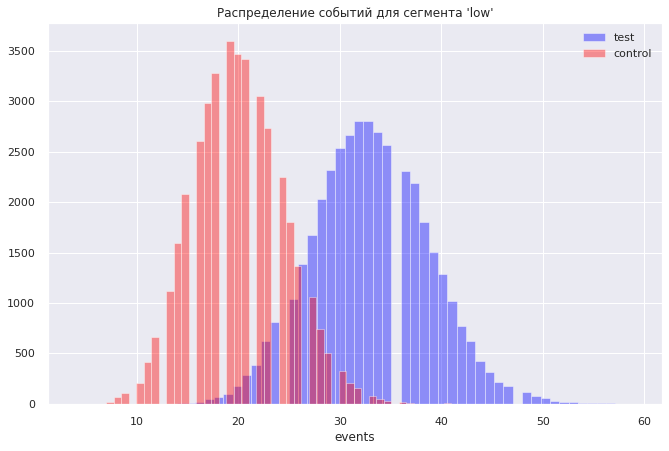

In [20]:
plt.figure(figsize=(11, 7))
sns.distplot(exp2.query("segment == 'low' & group == 'test'")['events'],
             label='test', kde=False, color="blue")

sns.distplot(exp2.query("segment == 'low' & group == 'control'")['events'],
             label='control', kde=False, color="red")

plt.title("Распределение событий для сегмента 'low'")
plt.legend()
plt.show()

	Общая цель графиков:
		Выявить различия в поведении пользователей из разных сегментов (high/low) при использовании тестовой и контрольной кнопок.
		Что показывают графики:
	1.	В сегменте low тестовая группа демонстрирует явное увеличение метрики events по сравнению с контрольной.
	2.	В сегменте high различия между группами менее выражены, но тестовая группа также имеет немного больший показатель events.

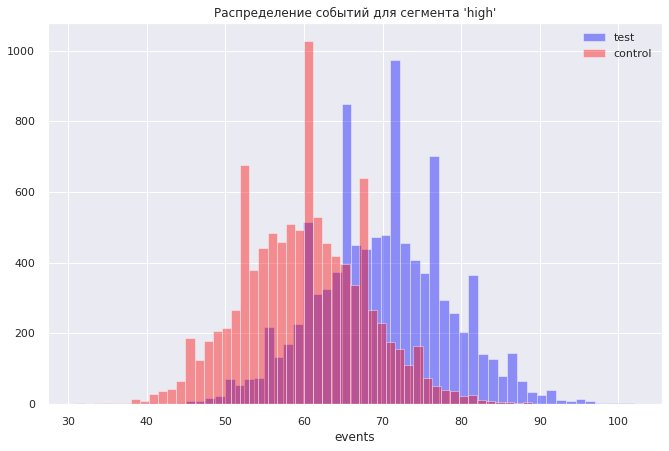

In [21]:
plt.figure(figsize=(11, 7))
sns.distplot(exp2.query("group == 'test' & segment == 'high'")['events'],
             label='test', kde=False, color="blue")

sns.distplot(exp2.query("group == 'control' & segment == 'high'")['events'],
             label='control', kde=False, color="red")

plt.title("Распределение событий для сегмента 'high'")
plt.legend()
plt.show()

Вывод по графикам

		Практическая значимость:
		Сегмент low показывает значительный прирост событий в тестовой группе, что указывает на положительное влияние новой кнопки.
        
		Для сегмента high эффекты менее выражены, но в тестовой группе наблюдаются незначительные улучшения

In [23]:
exp2.head()

,id,group,segment,events
0,83440,test,high,78.0
1,96723,test,high,71.0
2,68719,test,high,80.0
3,50399,test,high,80.0
4,95613,test,high,78.0


ANOVA-анализ с учетом взаимодействия факторов

Проверим, как два фактора (group - тест/контроль, segment - high/low) влияют на метрику events

In [28]:
anova_results = pg.anova(data=exp2, dv='events', between=['group', 'segment'])
print(anova_results)

            Source            SS       DF            MS              F  \
0            group  3.837195e+06      1.0  3.837195e+06  112031.864119   
1          segment  2.362480e+07      1.0  2.362480e+07  689756.377484   
2  group * segment  3.664244e+04      1.0  3.664244e+04    1069.823273   
3         Residual  3.424956e+06  99996.0  3.425093e+01            NaN   

           p-unc       np2  
0   0.000000e+00  0.528383  
1   0.000000e+00  0.873383  
2  2.060261e-233  0.010585  
3            NaN       NaN  


Основные показатели, на которые стоит обратить внимание:
	1.	P-value (p-unc):
	•	Если значение p-unc меньше 0.05, то фактор или взаимодействие факторов считаются статистически значимыми.
	•	В данном случае все три источника (group, segment, group * segment) имеют p-unc = 0.0000, что указывает на их значимое влияние на метрику events.
    
	2.	Частичный η² (np2):
	•	Показывает, насколько сильно фактор влияет на метрику:
	•	group (np2 = 0.528): Высокий эффект — около 53% дисперсии объясняется фактором тест/контроль.
	•	segment (np2 = 0.873): Очень сильный эффект — около 87% дисперсии объясняется сегментом low/high.
	•	group * segment (np2 = 0.011): Умеренный эффект взаимодействия (около 1.1%).
    
	3.	F-статистика (F):
	•	Чем выше значение F, тем сильнее влияние фактора на метрику.
	•	Важно учитывать совместно с p-value, чтобы понять значимость фактора.

Комментарий:
	•	Значения p-unc подтверждают значимость факторов, поэтому они должны быть учтены при принятии решений.
	•	Высокое значение η² у сегмента (segment) указывает на то, что данный фактор имеет ключевое влияние на поведение пользователей.
	•	Умеренный размер эффекта взаимодействия (group * segment) указывает на то, что тестовая кнопка может по-разному влиять на сегменты low и high.
    
Нам надо:

	•	Разработать отдельные стратегии для каждого сегмента (low/high).
	•	Тестовая кнопка может быть особенно эффективной для пользователей из сегмента low.

In [29]:
# Создание модели с учетом взаимодействий
model = smf.ols(formula='events ~ segment + group + segment:group', data=exp2).fit()

# Вывод результатов
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 events   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                 2.676e+05
Date:                Fri, 20 Dec 2024   Prob (F-statistic):               0.00
Time:                        13:08:51   Log-Likelihood:            -3.1858e+05
No. Observations:              100000   AIC:                         6.372e+05
Df Residuals:                   99996   BIC:                         6.372e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       59.9708      0.059   1024.716      0.000      59.856      60.086
segment[T.low]                 -39.9392      0.065   -610.391      0.000     -40.067     -39.811
group[T.test]                    9.9677      0.083    120.433      0.000       9.805      10.130
segment[T.low]:group[T.test]     3.0266      0.093     32.708      0.000       2.845       3.208
==============================================================================
Omnibus:                     1696.036   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2790.624
Skew:                           0.157   Prob(JB):                         0.00
Kurtosis:                       3.756   Cond. No.                         11.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Краткие объяснения ключевых показателей модели регрессии
	1.	R-squared и Adj. R-squared:
		R-squared (0.889): Означает, что модель объясняет 88.9% дисперсии метрики events.
		Adj. R-squared: Учитывает количество предикторов и подтверждает, что модель хорошо объясняет данные, избегая переобучения.
	2.	F-statistic и Prob (F-statistic):
		F-statistic (2.676e+05): Высокое значение указывает на значимость всей модели.
		Prob (F-statistic) = 0.00: Говорит о том, что модель статистически значима.
	3.	Коэффициенты (coef):
		Intercept (59.97): Среднее значение метрики events для контрольной группы сегмента high.
		segment[T.low] (-39.94): Указывает на снижение events на ~40 для сегмента low относительно high.
		group[T.test] (9.96): Тестовая кнопка увеличивает events на ~10 по сравнению с контрольной.
		segment[T.low]:group[T.test] (3.03): Взаимодействие сегмента low и тестовой кнопки добавляет ещё ~3 к events.
	4.	P>|t|:
		Значения всех коэффициентов имеют P>|t| = 0.000, что говорит о статистической значимости всех факторов и их взаимодействия.
	5.	Метрики качества модели:
		AIC и BIC (6.372e+05): Используются для сравнения моделей. Меньшие значения лучше.
		Durbin-Watson (2.007): Указывает на отсутствие автокорреляции остатков (близко к 2 — хорошо).

Вывод
		Сегмент: Важен для прогнозирования, так как сегмент low показывает снижение events на ~40 по сравнению с high.
		Кнопка: Тестовая кнопка положительно влияет на events, увеличивая их на ~10.
		Взаимодействие: Для сегмента low тестовая кнопка дополнительно увеличивает events на ~3.
		Модель: Статистически значима, с высоким качеством объяснения данных (R-squared = 88.9%).

In [30]:
# Построение модели
model = smf.ols(formula='events ~ segment + group + segment:group', data=exp2).fit()

# Проведение ANOVA
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                     sum_sq       df              F         PR(>F)
segment        2.362480e+07      1.0  689756.377484   0.000000e+00
group          3.837195e+06      1.0  112031.864119   0.000000e+00
segment:group  3.664244e+04      1.0    1069.823273  2.060261e-233
Residual       3.424956e+06  99996.0            NaN            NaN


Что означают ключевые показатели в таблице ANOVA?

		sum_sq (Sum of Squares): Сумма квадратов отклонений, отражающая вклад каждого фактора в вариацию зависимой переменной.
        
		df (Degrees of Freedom): Число степеней свободы для каждого фактора.
        
		F: Значение F-статистики, показывающее, насколько значим вклад фактора.
        
		PR(>F) (p-value): Вероятность получения такого значения F-статистики при условии, что эффект отсутствует.
        
		Если p-value < 0.05, фактор считается статистически значимым.

In [33]:
# pingouin
pg.anova( data = exp2, dv = 'events', between = ['segment', 'group'] )

,Source,SS,DF,MS,F,p-unc,np2
0,segment,2.362480e+07,1.0,2.362480e+07,689756.377484,0.000000e+00,0.873383
1,group,3.837195e+06,1.0,3.837195e+06,112031.864119,0.000000e+00,0.528383
2,segment * group,3.664244e+04,1.0,3.664244e+04,1069.823273,2.060261e-233,0.010585
3,Residual,3.424956e+06,99996.0,3.425093e+01,NaN,NaN,NaN


Выводы из таблицы:
	1.	segment:
		Значение p-value: 0.000000e+00.
		Это означает, что сегмент пользователя существенно влияет на количество событий.
	2.	group:
		Значение p-value: 0.000000e+00.
		Это подтверждает значительное влияние группы кнопки на количество событий.
	3.	segment:group (взаимодействие):
		Значение p-value: 2.060261e-233.
		Это указывает на то, что взаимодействие между сегментом пользователя и группой кнопки также значимо.

In [36]:
# Создаем новую колонку combination для комбинаций group и segment
exp2['combination'] = exp2['group'] + '/' + exp2['segment']

# Применяем pairwise_tukey для проверки статистически значимых различий
# Выполняем тест
tukey_results = pairwise_tukeyhsd(
    endog = exp2['events'],  # Зависимая переменная
    groups = exp2['combination'],  # Группы (combination)
    alpha = 0.05  # Уровень значимости
)

# Печатаем результаты
print(tukey_results)

# Вывод таблицы результатов
tukey_summary = pd.DataFrame(data = tukey_results.summary().data[1:],
                             columns = tukey_results.summary().data[0])
display(tukey_summary)

      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1       group2   meandiff p-adj  lower    upper   reject
----------------------------------------------------------------
control/high control/low -39.9392 0.001 -40.1073 -39.7711   True
control/high   test/high   9.9677 0.001   9.7551  10.1803   True
control/high    test/low -26.9449 0.001  -27.113 -26.7768   True
 control/low   test/high  49.9069 0.001  49.7388   50.075   True
 control/low    test/low  12.9944 0.001   12.888  13.1007   True
   test/high    test/low -36.9126 0.001 -37.0807 -36.7445   True
----------------------------------------------------------------


,group1,group2,meandiff,p-adj,lower,upper,reject
0,control/high,control/low,-39.9392,0.001,-40.1073,-39.7711,True
1,control/high,test/high,9.9677,0.001,9.7551,10.1803,True
2,control/high,test/low,-26.9449,0.001,-27.1130,-26.7768,True
3,control/low,test/high,49.9069,0.001,49.7388,50.0750,True
4,control/low,test/low,12.9944,0.001,12.8880,13.1007,True
5,test/high,test/low,-36.9126,0.001,-37.0807,-36.7445,True


Что ищем в результатах:
	1.	Mean Difference (meandiff): разницу между средними значениями двух групп.
	2.	p-adj: скорректированное p-значение. Если оно меньше 0.05, то различие значимо.
	3.	Reject: True, если различие значимо, и False, если нет.

Доверительные интервалы (lower/upper):
	
    Доверительные интервалы не содержат нуля, что подтверждает наличие статистически значимых различий между группами.

Вывод:
	
    Результаты показывают, что изменения в группе и сегменте (low/high) существенно влияют на количество событий.
	
    На основании meandiff и доверительных интервалов, можно сказать, что наибольшее влияние на метрику оказывает сегмент high и группы с изменённым форматом (например, test/high).

In [37]:
pg.pairwise_tukey(data = exp2, dv = 'events', between = 'combination')

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,control/high,control/low,59.970800,20.031575,39.939225,0.065432,610.391461,0.001,6.824282
1,control/high,test/high,59.970800,69.938500,-9.967700,0.082766,-120.432523,0.001,-1.703109
2,control/high,test/low,59.970800,33.025925,26.944875,0.065432,411.798717,0.001,4.603981
3,control/low,test/high,20.031575,69.938500,-49.906925,0.065432,-762.727892,0.001,-8.527429
4,control/low,test/low,20.031575,33.025925,-12.994350,0.041383,-314.002699,0.001,-2.220314
5,test/high,test/low,69.938500,33.025925,36.912575,0.065432,564.135148,0.001,6.307128


PointPlot показывает тренд среднего значения и позволяет оценить влияние факторов group и segment.

BoxPlot демонстрирует вариативность данных, медианы и выбросы, что важно для понимания устойчивости изменений.

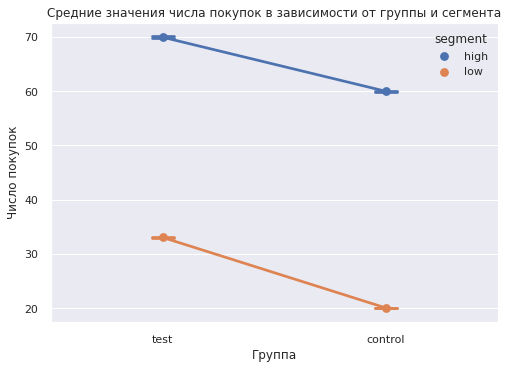

In [38]:
# PointPlot: Среднее значение метрики events для каждой группы (test и control), разделённой на сегменты (high и low)
sns.pointplot(
    x='group', y='events', hue='segment', data=exp2, capsize=0.1
)
plt.xlabel("Группа")  # Подпись для оси X
plt.ylabel("Число покупок")  # Подпись для оси Y
plt.title("Средние значения числа покупок в зависимости от группы и сегмента")  # Заголовок графика
plt.show()

    Этот график иллюстрирует среднее значение метрики events для каждой группы (test и control), разделённой на сегменты (high и low).
    Видно, что в тестовой группе (test) наблюдается более высокое значение метрики, особенно в сегменте high, что может свидетельствовать о положительном эффекте новой версии кнопки для данной категории пользователей.
    Сегмент low показывает менее выраженный рост, но тенденция также положительная.

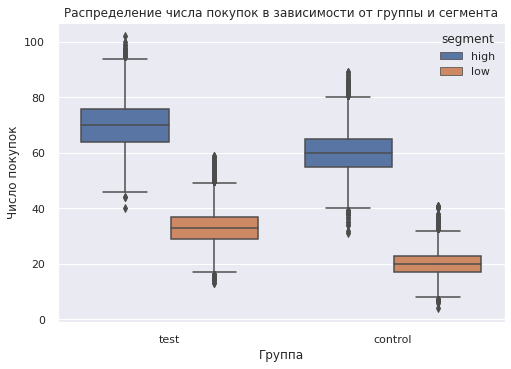

In [39]:
# BoxPlot: Распределение значений метрики events для каждой комбинации группы (test, control) и сегмента (high, low)
sns.boxplot(
    x='group', y='events', hue='segment', data=exp2
)
plt.xlabel("Группа")  # Подпись для оси X
plt.ylabel("Число покупок")  # Подпись для оси Y
plt.title("Распределение числа покупок в зависимости от группы и сегмента")  # Заголовок графика
plt.show()

BoxPlot 
    Позволяет визуализировать распределение значений метрики events для каждой комбинации группы (test, control) и сегмента (high, low).
    
	В сегменте high медианы значений значительно выше в тестовой группе, а распределение имеет меньшую вариативность.
    
	В сегменте low также видно улучшение в тестовой группе, хотя разброс данных больше.

### Заключительный вывод
	•	Фактор group (тестовая или контрольная группа) и фактор segment (сегмент high или low) оказались значимыми для метрики events, как показали результаты ANOVA и визуализация.
	•	Новая версия кнопки (тестовая группа) улучшила показатели для обеих сегментов, особенно для сегмента high, где наблюдается заметный рост.
	•	Рекомендация: На основе результатов анализа и графиков, можно рекомендовать выкатить новую версию кнопки для всех пользователей, уделяя особое внимание сегменту high, где эффект наиболее выражен.